# abrupt-0p5xCO₂ in Pymagicc
##### CC-BY 4.0 2020 @safiume, https://github.com/hsbay/cdrmex¶

In [1]:
##### Abrupt .5% decrease in CO₂ concentration
##### Pymagicc https://pymagicc.readthedocs.io/ AGPL-3.0, 
##### and MAGICC6, http://www.magicc.org/download6, CC-BY-NC-SA-4.0,
##### CDR calibration file and experiment

In [2]:
# NBVAL_IGNORE_OUTPUT
from os.path import join, abspath, split
from datetime import datetime
import sys, dateutil
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
print("Python verison:", sys.version)

Python verison: 3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


In [3]:
import pymagicc
from pymagicc import MAGICC6, rcp26
from pymagicc.io import MAGICCData
print("Pymagicc version:", pymagicc.__version__)
print("Scenario API", rcp26.__class__.__bases__)

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


Pymagicc version: 2.0.0rc8+19.g7aade1e.dirty
Scenario API (<class 'scmdata.run.ScmRun'>,)


In [4]:
graphstart = 1848
graphend = 2000
SCEN_DIR = "SCEN"
co2_conc_filename = "ABRUPT0P5XCO2_CO2_CONC.IN"
pymgc_hm = "pymagicc_1.3.2"

# Turn off emissions caculations by forcing emissions
# to switch on post experiment. Climate sensitivity 
# can be tuned to emulate ESMs.

# See 'Reduced complexity model intercomparison project phase 
# 1: Protocol, results and initial observations' 
# https://doi.org/10.5194/gmd-2019-375 for more details on 
# calibrating.

magcfg = {
    'startyear' : graphstart,
    'endyear': graphend,
    'out_inverseemis': 1,
    'core_climatesensitivity' : 3.257,            # [2.4-3.5] best linefits for 2015-2020 Current Temps
    'core_feedback_qsensitivity': 0,
    'core_verticaldiffusivity' : 2,
    'core_verticaldiffusivity_min' : 0.1,
    'core_verticaldiff_top_dkdt' : 0,
    'core_adjust_sst2ocnatm' : 1.25,
    'core_rlo' : 1.45,
    'core_heatxchange_landocean' : 2.35,
    'core_amplify_ocn2land_heatxchng' : .9,
    'core_heatxchange_northsouth' : 3.45,
    'co2_preindco2conc' : 276.744,
    # f_terr initial bin sizes
    'co2_gpp_initial' : 40,
    'co2_plantpool_initial' : 450,
    'co2_detrituspool_initial' : 85,
    'co2_soilpool_initial' : 1100,
    'co2_respiration_initial' : 12,
    # start of fluxes ∆
    'co2_fraction_gpp_2_plant' : 0.305,
    'co2_fraction_gpp_2_detritus' : 0.3,
    'co2_fraction_plant_2_detritus' : 0.35,
    'co2_fraction_detritus_2_soil' : 0.3,
    'co2_fraction_deforest_plant' : 0.29,
    'co2_fraction_deforest_detritus' : .4,
    'co2_tempfeedback_yrstart' : 1750,
    'co2_tempfeedback_switch' : 1,
    'co2_feedbackfactor_gpp' : 0,
    'co2_feedbackfactor_detritus' : 0,
    'co2_feedbackfactor_soil' : 0.046,
    'co2_feedbackfactor_respiration' : 0,
    'co2_fertilization_yrstart' : 1750,
    'co2_fertilization_method' : 1.03,
    'co2_fertilization_factor' : .63,
    'co2_gifford_conc_for_zeronpp' : 31,
    'co2_norgrwth_frac_defo' : .5,
    'co2_switchfromconc2emis_year': 5000,
    'co2_tempfeedback_switch': 1,
    'rf_total_runmodus':"CO2",
    'rf_total_constantafteryr': 5000,    
}

vars = ["Surface Temperature",
        "Radiative Forcing",
        "Atmospheric Concentrations|CO2"]

In [5]:
# Copy abrupt-0p5xCO₂ idealized file to pymagicc/MAGICC6/run
# Workaround a pathing issue with magicc.run and putting files in pymagicc/MAGICC6/run
# glue on fullworking dir to provide full path to be copied by pymagicc.run
cwd = split(abspath('__file__'))[0]
SCEN_DIR = join(cwd, SCEN_DIR)
co2testfh = join(SCEN_DIR,co2_conc_filename)

In [6]:
# Date range for graphs
x = (datetime(graphstart, 1, 1), datetime(graphend, 1, 1))

# Adjust baseline temp to the mean of 1720 to 1800 
# per https://doi.org/10.1175/BAMS-D-16-0007.1
#
# Reassign startyear to include the year 1720.
if magcfg['startyear'] > 1720:
    magcfg['startyear'] = 1720

styr = 1720
eyr = 1800

selectftr = {
    "region": "World",
    "variable": "Surface Temperature",
    "year": range(magcfg["startyear"], magcfg["endyear"]),
}

def meanbln(scen,mgdata,**mcfg):
    origts = mgdata.timeseries()
    default = magicc.run(file_co2_conc=scen, **mcfg)
    pmean = default.filter(**selectftr).timeseries().loc[:,datetime(styr, 1, 1): datetime(eyr, 1, 1)].T.mean()
    defaultts = default.timeseries()
    updated = defaultts.xs((selectftr['variable']),level = ('variable'), drop_level=False).sub(pmean[0])
    origts.loc[updated.index.values] = updated
    return(MAGICCData(origts.copy()))

,,,,,,time,1600-01-01 00:00:00,1601-01-01 00:00:00,1602-01-01 00:00:00,1603-01-01 00:00:00,1604-01-01 00:00:00,1605-01-01 00:00:00,1606-01-01 00:00:00,1607-01-01 00:00:00,1608-01-01 00:00:00,1609-01-01 00:00:00,...,4991-01-01 00:00:00,4992-01-01 00:00:00,4993-01-01 00:00:00,4994-01-01 00:00:00,4995-01-01 00:00:00,4996-01-01 00:00:00,4997-01-01 00:00:00,4998-01-01 00:00:00,4999-01-01 00:00:00,5000-01-01 00:00:00
climate_model,model,region,scenario,todo,unit,variable,,,,,,,,,,,,,,,,,,,,,
unspecified,unspecified,World,abrupt0p5xCO2,SET,ppm,Atmospheric Concentrations|CO2,276.744,276.744,276.744,276.744,276.744,276.744,276.744,276.744,276.744,276.744,...,138.372,138.372,138.372,138.372,138.372,138.372,138.372,138.372,138.372,138.372


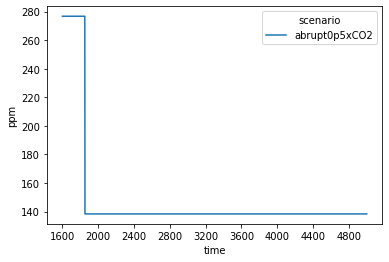

In [7]:
abtests = MAGICCData(join(SCEN_DIR, co2_conc_filename), columns={"scenario": ['abrupt0p5xCO2']})
abtests.metadata = {"header": 
                    "abrupt-0p5xCO2 experiment file, CO2 concentrations halve in 1850 pymagicc, doi.org/10.21105/joss.00516, AGPL-3.0 License"}
abtests.line_plot()
abtests.timeseries()

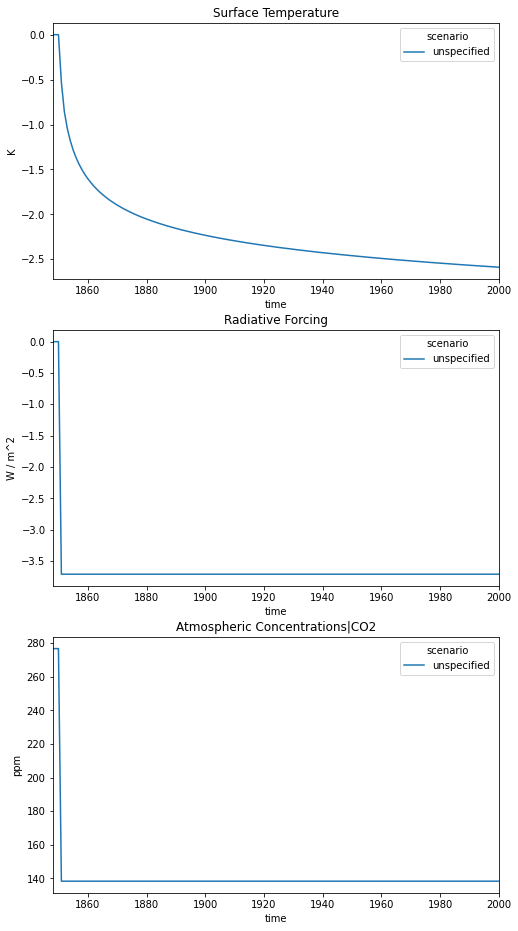

In [8]:
with MAGICC6() as magicc:
    tests = magicc.run(file_co2_conc = co2testfh, **magcfg)
    res = meanbln(co2testfh, tests, **magcfg)

fig, axes = plt.subplots((len(vars)), 1, figsize=(8, 16))
for n, var in enumerate(vars):
    res.filter(variable=var,region='World').lineplot(hue="scenario", ax=axes[n])
    ylab = res.filter(variable=var)["unit"].iloc[[0]].all()
    axes[n].set_ylabel(ylab)
    axes[n].set_title(var)                        
    axes[n].set_xlim(x)


In [9]:
res.filter(
    variable=["Surface Temperature", "Atmospheric Concentrations|CO2"], region="World"
).timeseries().loc[:, (datetime(1848, 1, 1, 0)) : (datetime(2000, 1, 1, 0))]

time                                                                                           1848-01-01  \
climate_model model       region scenario    todo         unit variable                                     
MAGICC6       unspecified World  unspecified not_relevant ppm  Atmospheric Concentrations|CO2     276.744   
                                                          K    Surface Temperature                  0.000   

time                                                                                           1849-01-01  \
climate_model model       region scenario    todo         unit variable                                     
MAGICC6       unspecified World  unspecified not_relevant ppm  Atmospheric Concentrations|CO2     276.744   
                                                          K    Surface Temperature                  0.000   

time                                                                                           1850-01-01  \
climate_model model       region scenario    todo         unit variable                                     
MAGICC6       unspecified World  unspecified not_relevant ppm  Atmospheric Concentrations|CO2     276.744   
                                                          K    Surface Temperature                  0.000   

time                                                                                           1851-01-01  \
climate_model model       region scenario    todo         unit variable                                     
MAGICC6       unspecified World  unspecified not_relevant ppm  Atmospheric Concentrations|CO2  138.372000   
                                                          K    Surface Temperature              -0.529974   

time                                                                                           1852-01-01  \
climate_model model       region scenario    todo         unit variable                                     
MAGICC6       unspecified World  unspecified not_relevant ppm  Atmospheric Concentrations|CO2   138.37200   
                                                          K    Surface Temperature               -0.85517   

time                                                                                           1853-01-01  \
climate_model model       region scenario    todo         unit variable                                     
MAGICC6       unspecified World  unspecified not_relevant ppm  Atmospheric Concentrations|CO2  138.372000   
                                                          K    Surface Temperature              -1.041921   

time                                                                                           1854-01-01  \
climate_model model       region scenario    todo         unit variable                                     
MAGICC6       unspecified World  unspecified not_relevant ppm  Atmospheric Concentrations|CO2  138.372000   
                                                          K    Surface Temperature              -1.177396   

time                                                                                           1855-01-01  \
climate_model model       region scenario    todo         unit variable                                     
MAGICC6       unspecified World  unspecified not_relevant ppm  Atmospheric Concentrations|CO2  138.372000   
                                                          K    Surface Temperature              -1.282989   

time                                                                                           1856-01-01  \
climate_model model       region scenario    todo         unit variable                                     
MAGICC6       unspecified World  unspecified not_relevant ppm  Atmospheric Concentrations|CO2   138.37200   
                                                          K    Surface Temperature               -1.36886   

time                                                               